In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pyodbc
from quetzal.model import stepmodel
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme import expressions as ex

In [2]:
input_path = '../input/'
output_path = '../outputs/'
model_path = '../model/'

# Calibrate the demand models

## Load data

Use survey data from: „Mobilität in Städten – SrV 2018“, Stichprobe Berlin, Senatsverwaltung für Mobilität, Verkehr, Klimaschutz und Umwelt Berlin, Abtei-lung Mobilität

In [3]:
# Establish an SQL connection to data base
def get_connection(file_name):
    connection_string = (
        r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        r"DBQ="+input_path+'transport_demand/SrV2018_B_Access/'+file_name+";"
    )
    #connection_url = sa.engine.URL.create(
    #    "access+pyodbc",
    #    query={"odbc_connect": connection_string},
    #)
    engine = pyodbc.connect(connection_string)
    #engine = sa.create_engine(connection_url)
    return engine

In [4]:
# Load data
engine = get_connection("SrV2018_Einzeldaten_Berlin_SciUse.accdb")
trip_cols = ['HHNR', 'PNR', 'WNR', 'GEWICHT_W', 'E_RVA', # general
             'V_START_LAGE', 'V_START_PLZ', 'V_ZIEL_LAGE', 'V_ZIEL_PLZ', # origin, destination
             'V_LAENGE', 'GIS_LAENGE', 'E_DAUER', 'E_GESCHW', # length, duration
             'V_ZWECK', 'V_BEGLEITUNG_OHNE', 'E_QZG_17', # purpose
             'V_UMSTIEG_ANZAHL', 'V_F_ANZAHL', # trip characteristics
             'V_VM_LAENG', 'E_HVM', 'E_HVM_4' # mode
            ]# + ['V_VM_REIHE_'+str(i) for i in range(1,9)]
trips = pd.read_sql_query(sql="select " + ", ".join(trip_cols) + " from W2018", con=engine)
persons_cols = ['HHNR', 'PNR', 'GEWICHT_P', 'E_ERW_3', 'E_ZUGANG_PKW',
                'E_MOBIL2', 'E_ANZ_WEGE2', 
                'E_OEV_FK']
persons = pd.read_sql_query(sql="select " + ", ".join(persons_cols) + " from P2018", con=engine)
codes = pd.read_sql_query(sql="select * from tblDatenkodierung", con=engine)
engine.close()

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\441022540.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trips = pd.read_sql_query(sql="select " + ", ".join(trip_cols) + " from W2018", con=engine)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\441022540.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  persons = pd.read_sql_query(sql="select " + ", ".join(persons_cols) + " from P2018", con=engine)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\441022540.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [5]:
# Number of trips by type
trips['E_RVA'].map(codes.loc[codes['Variable']=='E_RVA'].set_index('Kodierungsnr')['Kodierungstext']).value_counts()

E_RVA
Binnenverkehr               123917
Quellverkehr                  3131
Zielverkehr                   3048
Außenverkehr                  1122
Berechnung nicht möglich        16
Name: count, dtype: int64

In [139]:
# Make zip codes integer
trips['V_START_PLZ'] = trips['V_START_PLZ'].astype(int)
trips['V_ZIEL_PLZ'] = trips['V_ZIEL_PLZ'].astype(int)

In [143]:
# Filter
trips = trips.loc[(trips['E_RVA']==1) # within Berlin
                  & (trips['E_DAUER']!=-7) # reasonable duration
                  & (trips['V_LAENGE']>1) # reasonable distance
                  & (trips['V_LAENGE']<50) # reasonable distance
                  & (trips['E_QZG_17']!=-7) # reasonable purpose
                  & (trips['E_HVM_4']!=-7) # reasonable mode
                  & (trips['V_START_PLZ']>10000) # zip code reported
                  & (trips['V_ZIEL_PLZ']>10000) # zip code reported
                  & (trips['V_START_PLZ']<15000) # zip code reasonable
                  & (trips['V_ZIEL_PLZ']<15000) # zip code reasonable
                 ]
len(trips)

69899

In [7]:
# Merge person information with trips
trips['ID'] = trips['HHNR'].astype(str) + '_' + trips['PNR'].astype(str)
persons['ID'] = persons['HHNR'].astype(str) + '_' + persons['PNR'].astype(str)
persons.drop(columns=['HHNR', 'PNR'], inplace=True)
trips = trips.merge(persons, on='ID', how='left')

In [8]:
# Create mode categories
trips['mode'] = trips['E_HVM_4'] # 1: walk, 2: bike, 3: MIT, 4: PT
trips.loc[trips['E_HVM']==16, 'mode'] = 5 # Taxi
trips.loc[trips['E_HVM'].isin([5,8]), 'mode'] = 6 # Car sharing

In [9]:
# Filter for reasonable speeds
mode_max_speeds = {1: 10, 2: 25, 3: 60, 4: 60, 5: 60, 6: 60} #km/h
trips = trips.loc[trips['E_GESCHW']>1]
for mode, speed in mode_max_speeds.items():
    trips = trips.loc[~((trips['mode']==mode) & (trips['E_GESCHW']>speed))]
len(trips)

75423

In [10]:
# Filter for reasonable duration
trips = trips.loc[trips['E_DAUER']<200]
len(trips)

75405

In [11]:
# Drop observations that used private cars without car availability
trips = trips.loc[~((trips['E_ZUGANG_PKW']==0) & (trips['mode']==3))]
trips = trips.loc[trips['E_ZUGANG_PKW']!=-7]
len(trips)

71024

<Axes: ylabel='GEWICHT_W'>

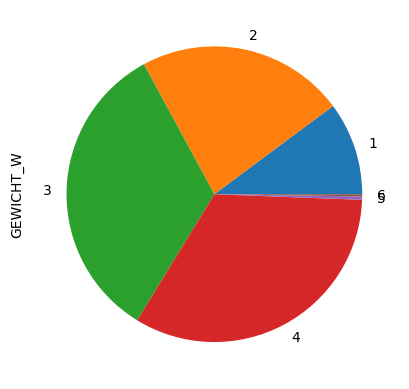

In [12]:
# Number of observations by mode
trips.groupby('mode').count()['GEWICHT_W'].plot.pie()

In [13]:
inf = 999999

## Mode choice

Calibrate a mode choice model

### Assign price data

Imputate prices of different modes based on survey distances and durations

In [163]:
# Add price attributes based on mode-specific assumptions
# See assumptions in 05_Simulation

# non-motorised
trips['price_walk'] = 0
trips['price_bike'] = 0

# Motorised individual traffic
trips['price_car'] = trips['V_LAENGE'] * 0.14 # EUR/km
trips['price_taxi'] = trips['V_LAENGE'] * 2.3 + 4
trips['price_car_sharing'] = trips['E_DAUER'] * 0.15 # EUR/min
#trips['V_LAENGE'] * 1 / 1000, # Miles (EUR/km)

# Public transport
trips['price_pt'] = trips['E_OEV_FK'].map(
    {1: 3.5, 2: 10/5, 3: 0,#49/30/4,
     60:0, 70:0, -8:3.5, -10:3.5})

### Time

Time imputation requires the network model for modes not chosen


In [77]:
# Load LoS table from model for travel times
sm = stepmodel.read_zippedpickles(model_path + 'los')

pt_los: 100%|██████████| 2/2 [00:08<00:00,  4.07s/it] 


In [111]:
# Get zip code data for zones
z = stepmodel.read_json(model_path + 'zones')
sm.zones = gpd.GeoDataFrame(z.zones, crs=4326)
plz = gpd.read_file(input_path + 'zone_shapes/plz_berlin.geojson')
plz = plz.to_crs(4326)
sm.zones['geometry'] = sm.zones.centroid
plz['geometry'] = plz.centroid
# Map zip codes to zone geometries
plz = gpd.sjoin_nearest(left_df=plz, right_df=sm.zones, how='right', distance_col='distance')['plz']

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\169761610.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sm.zones['geometry'] = sm.zones.centroid
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\169761610.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plz['geometry'] = plz.centroid
c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [123]:
# Add PLZ to LoS tables
def get_plz(zone):
    plr = zone.split('_')[1]
    z = eval(plz[plr])
    return max(set(z), key=z.count)
sm.pt_los['o_plz'] = sm.pt_los['origin'].apply(get_plz)
sm.pt_los['d_plz'] = sm.pt_los['destination'].apply(get_plz)
sm.car_los['o_plz'] = sm.car_los['origin'].apply(get_plz)
sm.car_los['d_plz'] = sm.car_los['destination'].apply(get_plz)

### Assign times of modes not chosen

Use travel time means per zip code connection for each mode because the survey does not contain explicit origins and destinations

In [126]:
# Create a LoS table
bins = [0, 1, 2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 40, 50, 60, 75]
labels = [i for i in bins[1:]]
sm.los = pd.concat([sm.pt_los, sm.car_los])
sm.los.loc[sm.los['all_walk']==True, 'length'] = sm.los.loc[sm.los['all_walk']==True, 'time'] * 5 / 3.6
sm.los = sm.los.loc[sm.los['length']>0]
sm.los.loc[sm.los['route_type']=='car', 'time'] += 2*3*60 # add parking time
sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'time'] += \
    sm.los.loc[sm.los['route_type'].isin(['bus', 'subway', 'tram', 'rail']), 'ntransfers'] * 2*60 # add transfer time
sm.los['bin'] = pd.cut(sm.los['length']/1000, bins, labels=labels)
sm.los['time'] = (sm.los['time'] / 60).astype(int)
sm.los['route_type'].replace(
    {'bike': 'bike', 'bus': 'pt', 'rail': 'pt', 'subway': 'pt', 'tram': 'pt'}, inplace=True)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\370914723.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sm.los['route_type'].replace(


In [127]:
# Add walking below certain distance
walk = sm.los.loc[(sm.los['route_type']=='bike') & (sm.los['length']<15000)].copy()
walk['route_type'] = 'walk'
walk['route_types'] = [('bike',) for i in walk.index]
walk['time'] = walk['length'] / 1000 / 6 * 60
sm.los = pd.concat([sm.los.loc[sm.los['route_type']!='walk'], walk]).reset_index(drop=True)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\2381292276.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sm.los.groupby(['bin', 'route_type'])['time'].mean().unstack().plot.bar(ylim=(0,120))


<Axes: xlabel='bin'>

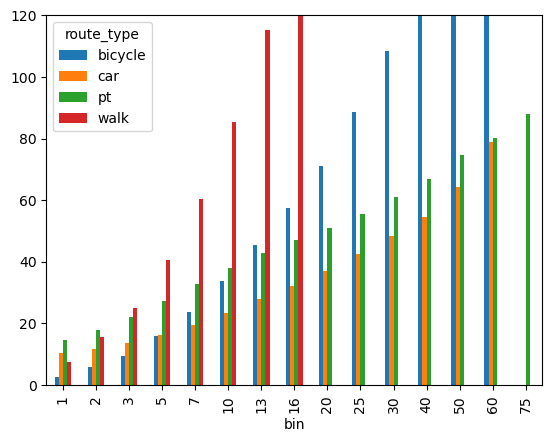

In [128]:
# Mean time distribution by mode
sm.los.groupby(['bin', 'route_type'])['time'].mean().unstack().plot.bar(ylim=(0,120))

<Axes: xlabel='bin'>

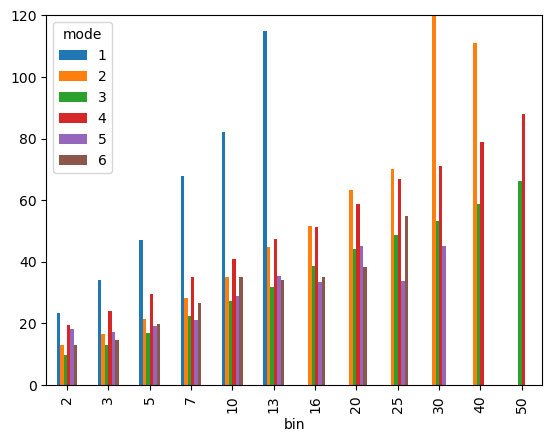

In [99]:
# In survey data
trips['bin'] = pd.cut(trips['V_LAENGE'], bins, labels=labels).astype(int)
trips.groupby(['bin', 'mode'])['E_DAUER'].mean().unstack().plot.bar(ylim=(0,120))

In [152]:
# Add time to calibration data
mode_dict = {1: 'walk', 2: 'bike', 3: 'car', 4: 'pt', 5: 'taxi', 6: 'car_sharing'}
time_mode_od = sm.los.groupby(['route_type', 'o_plz', 'd_plz'])['time'].mean()
time_mode_o_dist = sm.los.groupby(['route_type', 'o_plz', 'bin'])['time'].mean()
for i, mode in mode_dict.items():
    trips['time_'+mode] = np.nan
    mask = trips['mode']==i
    # Observed time for the chosen mode
    trips.loc[mask, 'time_'+mode] = trips.loc[mask, 'E_DAUER']
    # Synthetic times for other modes
    model_mode = mode if mode in sm.los['route_type'].unique() else 'car'
    trips.loc[~(mask), 'time_'+mode] = trips.loc[~(mask)].merge(
        time_mode_od[model_mode].to_frame(), left_on=['V_START_PLZ', 'V_ZIEL_PLZ'],
        right_index=True, how='left')['time']
    # Perform cost damping
    #trips['time_'+mode] = np.power(np.log(trips['time_'+mode]), 3)
    # Replace NaN with average values for that start zone in the corresponding ditance bin
    trips.loc[~(mask) & (trips['time_'+mode].isna()), 'time_'+mode] = \
        trips.loc[~(mask) & (trips['time_'+mode].isna())].merge(
            time_mode_o_dist[model_mode].to_frame(), left_on=['V_START_PLZ', 'bin'],
            right_index=True, how='left')['time']
    # Replace NaN with infinity
    trips['time_'+mode] = trips['time_'+mode].fillna(inf)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_10672\179129228.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_mode_o_dist = sm.los.groupby(['route_type', 'o_plz', 'bin'])['time'].mean()


In [151]:
# Generate availability columns based on time
for mode in mode_dict.values():
    trips['av_'+mode] = (trips['time_'+mode] != inf).astype(int)

In [155]:
for mode in mode_dict.values():
    print('Missing model time share for {}: {}'.format(
        mode, round(len(trips.loc[trips['time_'+mode]==inf])/len(trips), 3)*100))

Missing model time share for walk: 21.0
Missing model time share for bicycle: 13.0
Missing model time share for car: 12.3
Missing model time share for pt: 12.1
Missing model time share for taxi: 17.5
Missing model time share for car_sharing: 17.5


### Model formulation

Use biogeme notation. Split population by car availability and PT subscription.

In [156]:
# make database columns global variables
price_cols = [c for c in trips.columns if 'price' in c]
time_cols = [c for c in trips.columns if 'time' in c]
av_cols = [c for c in trips.columns if 'av_' in c]
db_all = db.Database('all_trips', trips[['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
globals().update(db_all.variables)

In [157]:
# Estimation parameters
# ASC
asc_walk = ex.Beta('asc_walk', 0, None, None, 0)
asc_bike = ex.Beta('asc_bike', 0, None, None, 0)
asc_car = ex.Beta('asc_car', 0, None, None, 0)
asc_pt = ex.Beta('asc_pt', 0, None, None, 1)
asc_taxi = ex.Beta('asc_taxi', 0, None, None, 0)
asc_car_sharing = ex.Beta('asc_car_sharing', 0, None, None, 0)
# Beta
b_t = ex.Beta('b_t', 0, None, 0, 0)
b_p = ex.Beta('b_p', 0, None, 0, 0)

In [158]:
# Utility functions
V_walk = asc_walk + b_t * time_walk + b_p * price_walk
V_bike = asc_bike + b_t * time_bike + b_p * price_bike
V_car = asc_car + b_t * time_car + b_p * price_car
V_pt = asc_pt + b_t * time_pt + b_p * price_pt
V_taxi = asc_taxi + b_t * time_taxi + b_p * price_taxi
V_car_sharing = asc_car_sharing + b_t * time_car_sharing + b_p * price_car_sharing
V = {1: V_walk,
     2: V_bike,
     3: V_car,
     4: V_pt,
     5: V_taxi,
     6: V_car_sharing}

In [159]:
# Availability formulation
A = {1: av_walk,
     2: av_bike,
     3: av_car,
     4: av_pt,
     5: av_taxi,
     6: av_car_sharing}

### Estimation

In [164]:
# Estimation
results = []
def estimate(database, writer, name):
    print('Sample size for {}: {}'.format(name, database.getSampleSize()))
    mnl = models.loglogit(V, A, mode) # Choose utility functions and availabilities
    formulas = {'loglike': mnl, 'weight': GEWICHT_W} # give weights to the estimator
    model = bio.BIOGEME(database, formulas)
    model.generate_html = False
    model.generate_pickle = False
    model.saveIterations = False
    model.modelName = name
    results.append(model.estimate()) # Estimation
    output = results[-1].getEstimatedParameters()
    # Add results to the Excel file
    for key, val in results[-1].getGeneralStatistics().items():
        output.loc[key] = [val[0], val[1]] + ['' for i in range(len(output.columns)-2)]
    output.to_excel(writer, sheet_name=model.modelName)

In [165]:
writer = pd.ExcelWriter(input_path + 'mode_choice_estimation.xlsx')
# with car without PT abo
name = 'car'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car, no PT abo
name = 'no_car'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & ~(trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# with car and pt abo
name = 'pt_abo_car'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==-1) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)
# No car and pt abo
name = 'pt_abo_no_car'
database = db.Database(name, trips.loc[(trips['E_ZUGANG_PKW']==0) & (trips['E_OEV_FK'].isin([3,60,70])),
                                       ['mode', 'GEWICHT_W']+price_cols+time_cols+av_cols])
estimate(database, writer, name)

# Save results
writer.close()

Sample size for car_no_pt_abo: 28799


The sum of the weights (25824.691946929244) is different from the sample size (28799). Multiply the weights by 1.115173031267249 to reconcile the two.


Sample size for no_car_no_pt_abo: 7597


The sum of the weights (8435.09395807119) is different from the sample size (7597). Multiply the weights by 0.9006420127342799 to reconcile the two.
It seems that the optimization algorithm did not converge. Therefore, the results may not correspond to the maximum likelihood estimator. Check the specification of the model, or the criteria for convergence of the algorithm.


Sample size for car_pt_abo: 15320


The sum of the weights (14661.197405738565) is different from the sample size (15320). Multiply the weights by 1.0449351151907669 to reconcile the two.


Sample size for no_car_pt_abo: 18183


The sum of the weights (21788.10067410068) is different from the sample size (18183). Multiply the weights by 0.8345380936124446 to reconcile the two.
It seems that the optimization algorithm did not converge. Therefore, the results may not correspond to the maximum likelihood estimator. Check the specification of the model, or the criteria for convergence of the algorithm.
